In [1]:
import os
fullpth = os.path.abspath(os.path.curdir)
while os.path.basename(os.path.abspath(os.path.curdir)) != 'multi-instance-mask-rcnn-extension':
    %cd ../

# %cd code/multi-instance-mask-rcnn-extension/

/home/adelgior/code/multi-instance-mask-rcnn-extension/scripts
The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.
/home/adelgior/code/multi-instance-mask-rcnn-extension


Exported /home/adelgior/workspace/images/000001_input.png


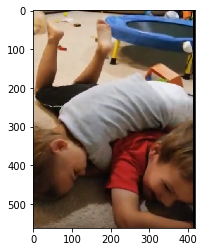

In [2]:
%matplotlib inline
import cv2
from multimaskextension.analysis.vis_utils import cv2_imshow, FigExporter

im = cv2.imread("./scripts/ipynb/sampledata/hudsonandluke.png")
im = im[:, :, ::-1]
cv2_imshow(im)
exporter = FigExporter()
exporter.export_gcf('input')


Config './detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


tensor([ 0,  0, 65], device='cuda:0')
Boxes(tensor([[ 28.2714,  41.2056, 417.8725, 551.2443],
        [176.2999, 241.2552, 415.9345, 555.9039],
        [385.2069,  79.8023, 412.3253, 110.2844]], device='cuda:0'))
Exported /home/adelgior/workspace/images/000003.png


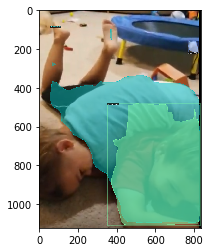

In [4]:
%matplotlib inline
from multimaskextension.train.script_utils import get_cfg, download_detectron_model_to_local_zoo, DETECTRON_REPO
from detectron2.engine import DefaultPredictor
import matplotlib.pyplot as plt

cfg = get_cfg()
config_filepath = f"{DETECTRON_REPO}/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
cfg.merge_from_file(config_filepath)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can either use the https://dl.fbaipublicfiles.... url, or use the
# following shorthand
model_rel_path = 'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl'
local_path = download_detectron_model_to_local_zoo(model_rel_path)
cfg.MODEL.WEIGHTS = local_path
predictor = DefaultPredictor(cfg)
# c. Get Mask R-CNN predictions and print boxes
outputs = predictor(im)

from pprint import pprint
pprint(outputs["instances"].pred_classes)
pprint(outputs["instances"].pred_boxes)

# d. Visualize and export Mask R-CNN predictions
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=2.0)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# cv2_imshow()
exporter.cv2_imwrite(v.get_image()[:, :, ::-1])
plt.imshow(v.get_image()[:,:,::-1])
# exporter.export_gcf('prediction')

In [6]:
# Don't know how to avoid importing this
# noinspection PyUnresolvedReferences
from multimaskextension.model import multi_roi_heads_apd
# noinspection PyUnresolvedReferences
from multimaskextension.data import registryextension
from multimaskextension.train import script_utils
from multimaskextension.train import trainer_apd
import torch

cpu = False
config_filepath = "output/logs/train/train_2021-06-21-162041_VCS-375c9c4_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0/config.yaml"
# config_filepath = "output/logs/test/train_2021-06-21-162041_VCS-375c9c4_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0/coco_2017_val/itr6400"
checkpoint = "output/logs/train/train_2021-06-21-162041_VCS-375c9c4_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0/model_checkpoints/model_064000.pth.tar"
cfg = script_utils.get_custom_maskrcnn_cfg(config_filepath, weights_checkpoint=checkpoint)
mymodel = trainer_apd.Trainer_APD.build_model(cfg)
print('Loading state dict')
state = torch.load(checkpoint, map_location=torch.device('cpu')) if cpu \
    else torch.load(checkpoint)
mymodel.load_state_dict(state['model_state_dict'])


Loading state dict


<All keys matched successfully>

In [17]:
%matplotlib inline
def detach_outputs(outputs):
    for f in outputs['instances']._fields:
        t = getattr(outputs['instances'], f)
        if torch.is_tensor(t):
            if t.requires_grad:
                t = t.detach()
        else:
            if t.tensor.requires_grad:
                t.tensor = t.tensor.detach()
                
import detectron2.data.transforms as T
def get_model_input(original_image):
    transform_gen = T.ResizeShortestEdge(
                [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
            )
    if cfg.INPUT.FORMAT == "RGB":
        # whether the model expects BGR inputs or RGB
        original_image = original_image[:, :, ::-1]
    height, width = original_image.shape[:2]
    image = transform_gen.get_transform(original_image).apply_image(original_image)
    image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
    inputs = {"image": image, "height": height, "width": width}
    return inputs

mymodel.eval()
inputs = get_model_input(im)
outputs, proposal_extras = mymodel([inputs], trace_proposals=True)
# print()


In [ ]:
detach_outputs(outputs)

from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=2.0)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# cv2_imshow()
exporter.cv2_imwrite(v.get_image()[:, :, ::-1])
# exporter.export_gcf('prediction')
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

import cv2
from matplotlib import pyplot as plt

#Show the image with matplotlib
plt.imshow(v.get_image()[:, :, ::-1])
plt.show()

In [25]:
outputs[1][0]

{'selected_proposal_idxs': tensor([ 10,   1, 172,  19,  62,  20], device='cuda:0'),
 'boxes': tensor([[ 6.7761e+01,  2.5978e+02,  7.8612e+02,  ...,  3.3034e+02,
           7.8843e+02,  9.6242e+02],
         [ 3.5255e+02,  4.8278e+02,  7.9528e+02,  ...,  5.6747e+02,
           7.9578e+02,  1.0455e+03],
         [ 2.3630e+02,  3.8580e+02,  7.8728e+02,  ...,  4.7061e+02,
           7.8917e+02,  1.0428e+03],
         ...,
         [ 2.0475e+02,  6.6762e+01,  2.4331e+02,  ...,  6.7121e+01,
           2.4165e+02,  8.4104e+01],
         [ 5.5269e+02, -1.0672e-01,  5.9484e+02,  ...,  1.0938e+00,
           5.9495e+02,  2.8663e+01],
         [ 7.4376e+02,  1.5555e+02,  7.8896e+02,  ...,  1.5476e+02,
           7.8797e+02,  2.1074e+02]], device='cuda:0',
        grad_fn=<SplitWithSizesBackward>),
 'scores': tensor([[7.2274e-01, 3.8058e-05, 1.6255e-04,  ..., 5.6151e-05, 3.5934e-05,
          9.6762e-02],
         [8.0662e-01, 2.0344e-05, 1.5629e-04,  ..., 1.7816e-05, 1.1573e-05,
          5.1202e

In [13]:
outputs['instances']._fields

{'pred_boxes': Boxes(tensor([[ 31.9234,  63.0542, 415.0689, 551.4493],
         [184.2061, 252.1604, 415.5316, 550.3498],
         [  0.0000,   4.9864, 210.7163, 251.8752],
         [  0.0000,  28.3566, 412.3629, 336.2306],
         [166.3934,  24.8769, 218.1050, 136.9011],
         [385.3896,  79.7350, 412.0991, 110.1944]], device='cuda:0')),
 'scores': tensor([0.8953, 0.8066, 0.7372, 0.6334, 0.5781, 0.5324], device='cuda:0',
        grad_fn=<IndexBackward>),
 'pred_classes': tensor([ 0,  0, 14,  0, 39, 65], device='cuda:0'),
 'pred_masks': tensor([[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],
 
         [[False, False, False,  ..., False, False, False],
          [Fals

In [ ]:
# visualize_single_image_output(img, metadata, pred_instances, proposals, image_id, extra_proposal_details=None,
#                                   scale=2.0, map_instance_to_proposal_vis=True, proposal_score_thresh=None,
#                                   exporter=None, visualize_just_image=False, basename='')


In [31]:
from detectron2.evaluation.evaluator import inference_context
inputs = [torch.from_numpy(im)]
model = mymodel
previously_training = model.training
model.eval()
with inference_context(model), torch.no_grad():
    # Get proposals
    images = model.preprocess_image(inputs)
    features = model.backbone(images.tensor)
    proposalss, proposal_lossess = model.proposal_generator(images, features, None)

    # Get instance boxes, masks, and proposal idxs
    outputs, extra_proposal_details = model(inputs, trace_proposals=True)

if previously_training:
    model.train()

all_outputs = {'outputs': outputs,
        'proposalss': proposalss,
        'proposal_lossess': proposal_lossess,
        'extra_proposal_details': extra_proposal_details
        }


ValueError: some of the strides of a given numpy array are negative. This is currently not supported, but will be added in future releases.

In [ ]:
#     outputs_d = run_inference(trainer, [dpt])
#     if masks_key is None:
#         pass
#     else:
#         assert masks_key.startswith('pred_masks')
#         for o in outputs_d['outputs']:
#             try:
#                 o['instances'].set('pred_masks_soft', o['instances'].get(masks_key + '_soft'))
#             except AttributeError:
#                 print(Warning('Soft scores not found: {}'.format(masks_key + '_soft')))
#             o['instances'].set('pred_masks', o['instances'].get(masks_key))
#     outputs = outputs_d['outputs'][0]

#     img, pred_instances, _ = script_utils.prep_for_visualization(cfg, input_image,
#                                                                  pred_instances=outputs['instances'],
#                                                                  proposals=None)
#     posttrain_tag = f'_posttrain_{max_iters}'
#     visualize_instancewise_predictions(
#         img, pred_instances, cfg, exporter, tag=f'{image_id}' + posttrain_tag + cfg_tag)
#     figure_name = image_id + cfg_tag + posttrain_tag + '_pred'
#     figname = exporter.collate_previous('{:02d}'.format(exporter.fig_number) + 'c_' + figure_name,
#                                         delete_individuals=True)
#     dbprint('Exported', figname)
#     vis_utils.visualize_instancewise_soft_predictions(
#         pred_instances, exporter, tag=f'{image_id}' + posttrain_tag + cfg_tag)
#     figure_name = image_id + cfg_tag + posttrain_tag + '_pred_soft'
#     figname = exporter.collate_previous('{:02d}'.format(exporter.fig_number) + 'c_' + figure_name,
#                                         delete_individuals=True)
#     dbprint('Exported', figname)
#     if show_pipeline:
#         script_utils.run_single_image_results_visualization(cfg, exporter, outputs_d['extra_proposal_details'][0],
#                                                             image_id, img, trainer.model, outputs, outputs_d[
#                                                                 'proposalss'][0],
#                                                             visualize_just_image=False)

#         figname = exporter.collate_previous(
#             '{:02d}'.format(exporter.fig_number) + 'c_' + os.path.splitext(os.path.basename(__file__))[
#                 0] + '_' + image_id + cfg_tag +
#             posttrain_tag + '_pipeline', delete_individuals=True)
#         dbprint('Exported', figname)
